In [1]:
import os
os.chdir("/Users/ulrikah/fag/thesis/rave")


In [23]:
import numpy as np
import matplotlib.pyplot as plt

from rave.sound import Sound
from rave.analyser import Analyser
from rave.constants import KSMPS, SAMPLE_RATE
from rave.tools import sec_per_k

**Analysis**

Files to analyse (in `results/analysis`):

- rms_1000iters.wav
- rms_1000iters_debug.wav
- all_1000iters.wav
- all_1000iters_debug.wav

What I want to get out:
- RMS plot of bounced_files
- pitch plot of bounces_files
- spectral plot of bounced_files
- upsampled control rate params on top of each other

What I maybe want to get out:
- reward (but that requires the reward to be normalized)

**Retrieving the features**

In [9]:
feature_extractors = ["rms", "pitch", "spectral"]
analyser = Analyser(feature_extractors)

rms_bounce = "/Users/ulrikah/fag/thesis/results/analysis/rms_1000iters.wav"
all_bounce = "/Users/ulrikah/fag/thesis/results/analysis/all_1000iters.wav"
target     = "/Users/ulrikah/fag/thesis/rave/rave/input_audio/amen_trim.wav"

rms_sound = Sound(rms_bounce)
all_sound = Sound(all_bounce)
target_sound = Sound(target)
sounds = [rms_sound, all_sound, target_sound]
for sound in sounds:
    sound.prepare_to_render(analyser=analyser)
    sound.features = []

done = False

while not done:
    for sound in sounds:
        done = done or sound.render()
        channel_values = sound.player.get_channels(analyser.analysis_features)
        sound.features.append(channel_values)
print("Number of feature vectors", [len(s.features) for s in sounds])
print("(sr / ksmps) * duration", (SAMPLE_RATE / KSMPS) * sounds[0].duration)

Number of feature vectors [1445, 1445, 1445]
(sr / ksmps) * duration 1722.9999999999998


**Visualisation**

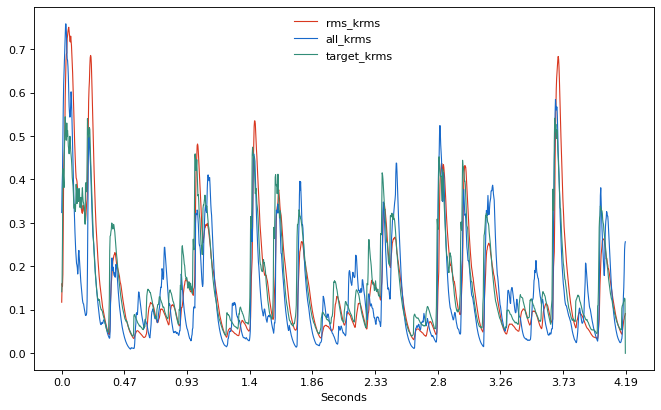

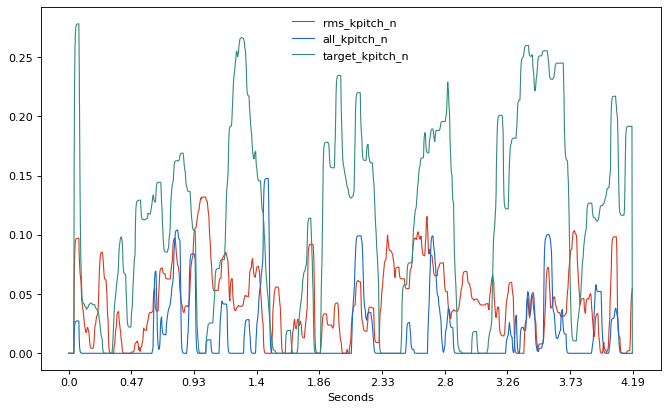

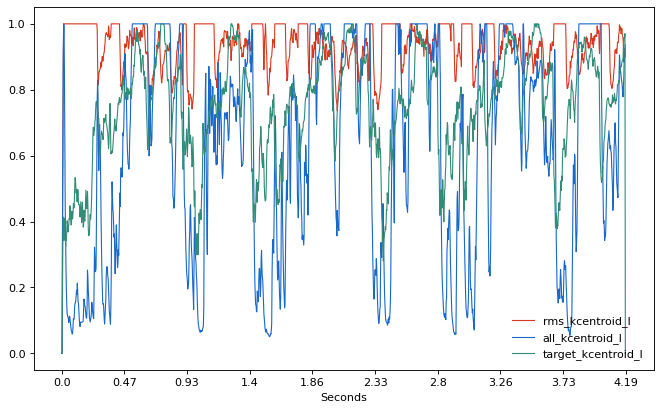

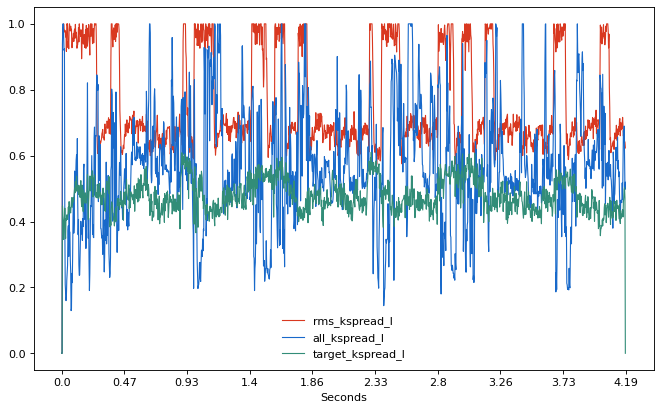

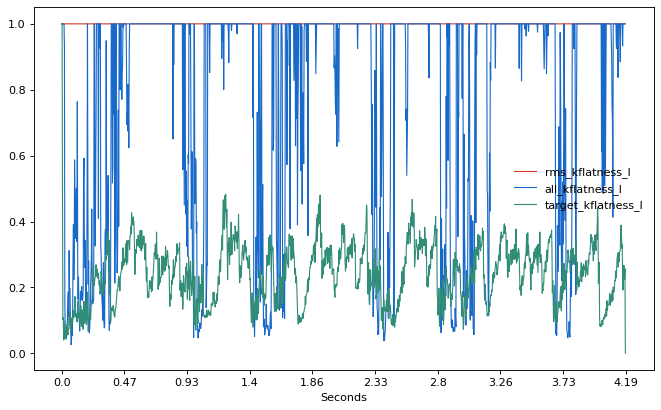

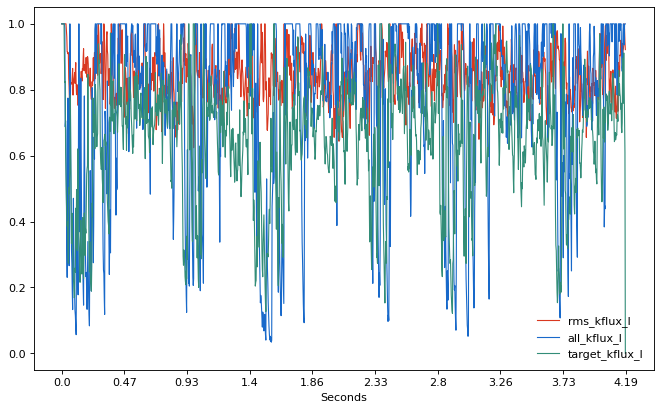

In [43]:
# numpyify
for sound in sounds:
    sound.features = np.array(sound.features)

sound_names = ["rms", "all", "target"]
sound_colors = [
    np.array([0.85181538, 0.22025192, 0.12469306]), 
    np.array([0.0950709 , 0.41044936, 0.79145089]),
    np.array([0.19786649, 0.55163671, 0.47055379])
]
n_frames = len(sounds[0].features)
n_ticks = 10
x_tick_values = np.linspace(0, n_frames, num=n_ticks)
x_tick_labels = [str(round(tick, 2)) for tick in x_tick_values * sec_per_k(KSMPS, SAMPLE_RATE)]

for i, feature_name in enumerate(analyser.analysis_features):
    plt.figure(figsize=(10,6), dpi=80)
    for j, sound in enumerate(sounds):
        feature = sound.features[:n_frames,i]
        plt.plot(feature, c=sound_colors[j], label=f"{sound_names[j]}_{feature_name}", linewidth=1, markersize=12)
        plt.xticks(x_tick_values,x_tick_labels)
        plt.xlabel("Seconds")
    plt.legend(frameon=False)
    plt.show()